<h2>ANN regression example 2 - Housing data with preprocessing</h2>

In [181]:
# pip install scikit-learn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics

# pip install tensorflow
import tensorflow as tf
import keras
from keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import load_model


In [182]:
SEED = 42
tf.config.experimental.enable_op_determinism()
tf.random.set_seed(SEED)

In [183]:
# load the data
df = pd.read_csv("Housing.csv")

In [184]:
# let's see what we have in the data
df.head(10)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished
5,10850000,7500,3,3,1,yes,no,yes,no,yes,2,yes,semi-furnished
6,10150000,8580,4,3,4,yes,no,no,no,yes,2,yes,semi-furnished
7,10150000,16200,5,3,2,yes,no,no,no,no,0,no,unfurnished
8,9870000,8100,4,1,2,yes,yes,yes,no,yes,2,yes,furnished
9,9800000,5750,3,2,4,yes,yes,no,no,yes,1,yes,unfurnished


<p>We can see in the data that we have many yes/no fields and one field with multiple text categories. We have to convert all of these correctly into numeric format.</p>

In [185]:
# quickly check if we have missing values
df.isna().sum()

price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64

<h3>Convert no/yes -columns into 0/1</h3>

In [186]:
# this just converts the value of column to 0 or 1
# factorize in pandas works too, but only one column at a time
from sklearn.preprocessing import LabelEncoder
variables = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
encoder = LabelEncoder()
df[variables] = df[variables].apply(encoder.fit_transform)

In [187]:
# works nicely!
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished


<h3>Convert text categories with multiple choices into multiple variables</h3>

In [188]:
def modify_furnisahingrow(row):
    if row["furnishingstatus"] == "unfurnished":
        return 0
    else:
        return 1

In [189]:
df["furnishing"]=df.apply(modify_furnisahingrow, axis=1)
df= df.drop("furnishingstatus", axis=1)
df= df.drop("bedrooms", axis=1)
df= df.drop("mainroad", axis=1)


In [190]:
# works nicely
df.head(10)

,price,area,bathrooms,stories,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishing
0,13300000,7420,2,3,0,0,0,1,2,1,1
1,12250000,8960,4,4,0,0,0,1,3,0,1
2,12250000,9960,2,2,0,1,0,0,2,1,1
3,12215000,7500,2,2,0,1,0,1,3,1,1
4,11410000,7420,1,2,1,1,0,1,2,0,1
5,10850000,7500,3,1,0,1,0,1,2,1,1
6,10150000,8580,3,4,0,0,0,1,2,1,1
7,10150000,16200,3,2,0,0,0,0,0,0,0
8,9870000,8100,1,2,1,1,0,1,2,1,1
9,9800000,5750,2,4,1,0,0,1,1,1,0


In [191]:
# printing out the column names for easier copying for X/y
df.columns

Index(['price', 'area', 'bathrooms', 'stories', 'guestroom', 'basement',
       'hotwaterheating', 'airconditioning', 'parking', 'prefarea',
       'furnishing'],
      dtype='object')

<h3>X/y -variables</h3>

In [192]:
# if you  have more than one independent variables, list them all here
# leave out the target variable! (dependent variable)
# in this case, everything else except the amount_paid
X = df[['area', 'bathrooms', 'stories',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea', 'furnishing']]

# have only the target variable here (dependent variable)
# in this case, amount_paid => how big is the electricity bill
y = df['price']

<h3>Train/test/validation -split</h3>

In [193]:
# unfortunately the scikit-learn's train_test_split doesn't support validation
# set split in itself.
# if you want to split the test set into two for a validation set too, try this trick:

# first, train/test split => 70% for training, 30% for other purposes (temp)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=101)

# now, split the 30% for other purposes by 50% (resulting in 2 x 15%)
# so finally, we have:
# 70% for training
# 15% for testing
# 15% for validation
# => 70 + 15 +15 = 100%
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=101)

In [194]:
# just seeing how much data we have in each
print(f"Train data amount: {len(X_train)}")
print(f"Test data amount: {len(X_test)}")
print(f"Validation data amount: {len(X_val)}")

Train data amount: 381
Test data amount: 82
Validation data amount: 82


In [195]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 

# VIF dataframe 
# VIF = Variance Inflation Factor
vif_data = pd.DataFrame() 
vif_data["feature"] = X.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                          for i in range(len(X.columns))] 
  

# variables with high VIF-value 
# can mean multlicollinearity (variables providing same linear
# relationships in the data, potentially confusing the ML algorithm
# this might be good info when deciding if some variable needs to be removed
print(vif_data)

           feature  VIF
0             area 6.35
1        bathrooms 7.80
2          stories 5.82
3        guestroom 1.46
4         basement 1.91
5  hotwaterheating 1.09
6  airconditioning 1.72
7          parking 1.95
8         prefarea 1.47
9       furnishing 3.12


<Axes: >

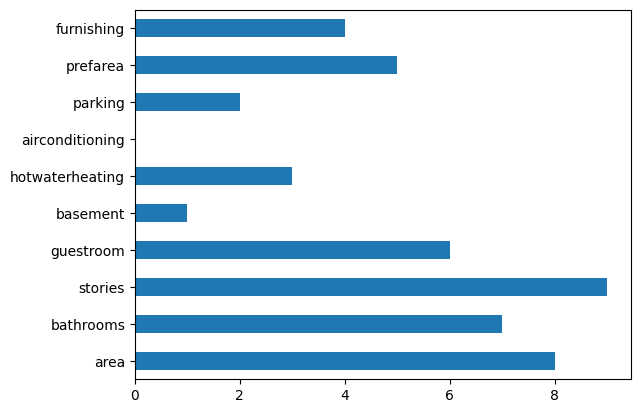

In [196]:
from skfeature.function.similarity_based import fisher_score

# get the fisher's score rankings 
ranks = fisher_score.fisher_score(X.values, y.values)

# create a pandas DataFrame for easier interpretation
feat_importances = pd.Series(ranks, X.columns)
feat_importances.plot(kind='barh')

# how to interpret -> low score means the effect of this field is not large in the dataset
# => typically means other columns in the dataset have similar correlations, 
# therefore making this particular column not so useful since other columns 
# already fill this role for this correlation

# Fisher's score studies the variance of the data -> statistical significance

In [197]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# convert all continuous variables to integer,
# and convert all negative numbers to 0
X_cat = X.astype(int)
X_cat = X_cat.clip(lower=0)

# initialize chi2 and SelectKBest
# Note: chi2 -test is a very common test
# in statistics and quantitative analysis
# basically it studies the data whether variables are related
# or independent of each other
chi_2_features = SelectKBest(chi2, k=len(X_cat.columns))

# fit our data to the SelectKBest
best_features = chi_2_features.fit(X_cat,y.astype(int))

# use decimal format in table print later
pd.options.display.float_format = '{:.2f}'.format

# wrap it up, and show the results
# the higher the score, the more effect that column has on price
df_features = pd.DataFrame(best_features.scores_)
df_columns = pd.DataFrame(X_cat.columns)
f_scores = pd.concat([df_columns,df_features],axis=1)
f_scores.columns = ['Features','Score']
f_scores.sort_values(by='Score',ascending=False)

,Features,Score
0,area,279446.07
7,parking,282.83
3,guestroom,248.50
5,hotwaterheating,224.40
8,prefarea,223.95
6,airconditioning,198.96
4,basement,171.89
2,stories,128.58
9,furnishing,90.89
1,bathrooms,64.33


<h3>Create neural network structure</h3>

In [198]:
variable_amount = len(X.columns)

# Define Sequential neural network model
# modify the input shape to match your training column count
# remember, one of the columns is removed from training columns
# to be the target value. so if your data originally had 10 columns
# the input shape is 9 ... (10 - 1 => 9)
# the input layer itself can have a different number of nodes
# Tip: have at least the same number of nodes as in the input shape
# output layer in regression is always 1 node without activation function

# create a model checkpoint to a file, and only save the best one
mc = ModelCheckpoint('best_model.keras', monitor='val_loss', mode='min', save_best_only=True)
callback_list = [mc]

model = keras.Sequential(
    [
        layers.BatchNormalization(input_shape=(variable_amount,)),
        layers.Dense(9, activation="relu", kernel_regularizer=keras.regularizers.l2(l2=0.1)),
        layers.Dense(18, activation="relu"),
        layers.Dense(1)
    ]
)

# select the optimizer and loss function
# you can try rmsprop also as optimizer, or stochastic gradient descent
model.compile(optimizer='adam', loss='mse')

# common tips on how to change neural network structure if your metrics are not good:

# make wider (or narrower) layers (for example, 64 or 128 nodes)
# make a longer or shorter network (add or remove layers)
# use Dropout -layers (e.g. layers.Dropout(0.1))

# remember: there's no process or mathematical formula
# in order to figure out the optimal neural network structure
# it's mostly all about trial and error => EXPERIMENTATION!

# remember to have enough "decision-space" for your data!
# it's highly unlikely a dataset with 20 different variables is going
# to work well with only 8 nodes in each layer etc.

# print out the summary of your model
model.summary()

/Users/kirillsobolev/Documents/GitHub/Deep-Learning/.venv/lib/python3.10/site-packages/keras/src/layers/normalization/batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_6           │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 9)              │            99 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 18)             │           180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            19 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 338 (1.32 KB)

 Trainable params: 318 (1.24 KB)

 Non-trainable params: 20 (80.00 B)

<h3>Train the neural network with our data</h3>

In [199]:
# using validation again for better metrics and optimization
model.fit(x=X_train, y=y_train, epochs=800, validation_data=(X_val, y_val), callbacks=callback_list)

Epoch 1/800
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 24387306651648.0000 - val_loss: 25236883898368.0000
Epoch 2/800
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 24387304554496.0000 - val_loss: 25236881801216.0000
Epoch 3/800
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 24387300360192.0000 - val_loss: 25236879704064.0000
Epoch 4/800
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 24387300360192.0000 - val_loss: 25236879704064.0000
Epoch 5/800
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 24387296165888.0000 - val_loss: 25236875509760.0000
Epoch 6/800
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 24387291971584.0000 - val_loss: 25236871315456.0000
Epoch 7/800
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 24387287777280.0000 - val_loss: 25236867121152.0000
Epoch 8/800
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 24387281485824.0000 - val_loss: 25236860829696.0000
Epoch 9/800
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 24387275194368.0000 - val_loss: 25236854538240.0000
E

<h3>Training metrics</h3>

<Axes: >

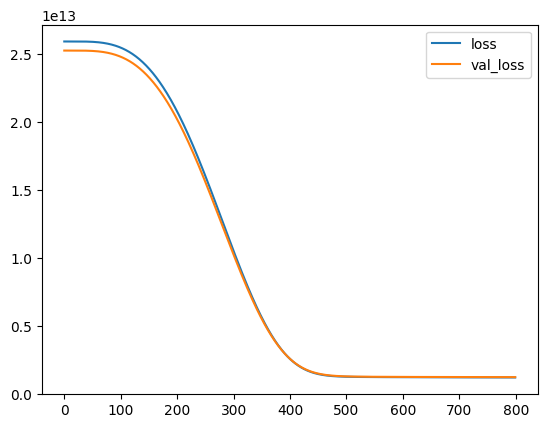

In [200]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

In [201]:
# compare test error values to training error values
# the model is often good when these error values are similar
# even if you training metrics above didn't overlap
# you might still get very close values in evaluation => more important

# compare the final model loss/evaluation values
print("Test data evaluation:")
print(model.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(X_train, y_train, verbose=0))

Test data evaluation:
1343154814976.0

Train data evaluation:
1102091386880.0


<h3>Make some test predictions to see what kind of mistakes the model makes</h3>

In [202]:
model = load_model('best_model.keras')

In [203]:
test_predictions = model.predict(X_test)

# reshape the data for easier comparison table
test_predictions = pd.Series(test_predictions.reshape(len(y_test),))
pred_df = pd.DataFrame(np.asarray(y_test), columns=['Test True Y'])
pred_df = pd.concat([pred_df, test_predictions], axis=1)
pred_df.columns = ['Test True Y', 'Model Predictions']

# print the comparison table - true values vs. model predicted values
# we can nicely see here how far off our model is in some cases
pred_df

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


,Test True Y,Model Predictions
0,7140000,5635887.50
1,4620000,4670689.00
2,8855000,7030397.00
3,2100000,2765856.00
4,4095000,3997377.25
...,...,...
77,3773000,4920238.00
78,4480000,4432650.50
79,4305000,5789048.00
80,4375000,2979678.00


<Axes: xlabel='Test True Y', ylabel='Model Predictions'>

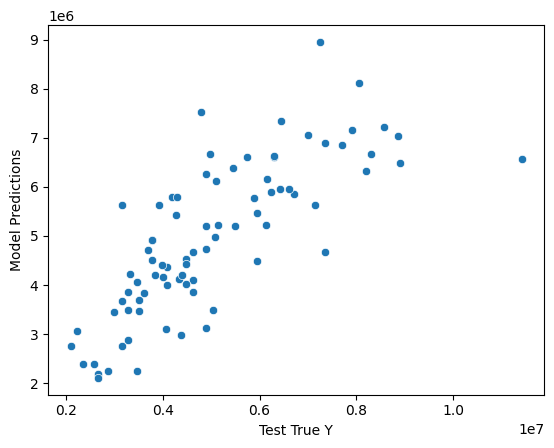

In [204]:
# these values follow a linear line = good predictions
# we basically compare the predicted values 
# to true test values and see the differences
sns.scatterplot(x='Test True Y', y='Model Predictions', data=pred_df)

<h3>Regression error metrics</h3>

In [205]:
# MAE - Mean average error
print("MAE")
print(round(metrics.mean_absolute_error(y_test, test_predictions), 2), "$")

# MSE - Mean square error
print("\nMSE")
print(round(metrics.mean_squared_error(y_test, test_predictions), 2), "$^2")

# RMSE - Root mean square error
print('\nRMSE:')
print(round(np.sqrt(metrics.mean_squared_error(y_test, test_predictions)), 2), "$")

# R-squared. 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
print('\nR-squared:')
print(round(metrics.r2_score(y_test, test_predictions), 2))

# Explained Variance Score => 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
# high variance score = model is a good fit for the data 
# low variance score = model is not a good fit for the data
# the higher the score, the model is more able to explain the variation in the data
# if score is low, we might need more and better data
print("\nExplained variance score:")
print(round(metrics.explained_variance_score(y_test, test_predictions), 2))

MAE
842890.25 $

MSE
1343154791763.14 $^2

RMSE:
1158945.55 $

R-squared:
0.6

Explained variance score:
0.6


/var/folders/19/0ldx1bc54jx5tvjkrsbcv4040000gn/T/ipykernel_23057/3124900743.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_test - test_predictions))


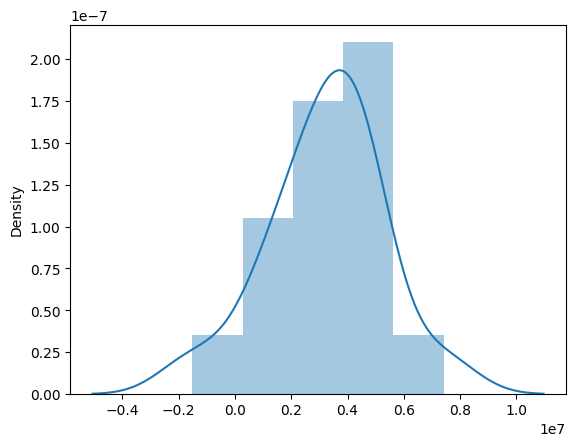

In [206]:
# if the prediction distribution are far from normal distribution
# then the model is not probably good enough
# distplot is deprecating in future pandas-version
# unfortunately, there's no exact alternative to do this plot at the moment
sns.distplot((y_test - test_predictions))
plt.show()
plt.close()

<h2>Lets' try the model in practice</h2>

In [207]:
X.columns

Index(['area', 'bathrooms', 'stories', 'guestroom', 'basement',
       'hotwaterheating', 'airconditioning', 'parking', 'prefarea',
       'furnishing'],
      dtype='object')

In [208]:
df.head()

,price,area,bathrooms,stories,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishing
0,13300000,7420,2,3,0,0,0,1,2,1,1
1,12250000,8960,4,4,0,0,0,1,3,0,1
2,12250000,9960,2,2,0,1,0,0,2,1,1
3,12215000,7500,2,2,0,1,0,1,3,1,1
4,11410000,7420,1,2,1,1,0,1,2,0,1


In [209]:
# let's try with some new imaginary data
# this example uses the student performance index score dataset
# modify this as needed regarding your own dataset
tester_row = {
    'area': 8500,
    'bedrooms': 4, 
    'bathrooms': 3, 
    'stories': 2,
    'mainroad': 1, 
    'guestroom': 1,
    'basement': 0, 
    'hotwaterheating': 1, 
    'airconditioning': 1, 
    'parking': 2, 
    'prefarea': 0,
    'furnishingstatus_furnished': 0, 
    'furnishingstatus_semi-furnished': 0
}

# convert to pandas-format
tester_row = pd.DataFrame([tester_row])

In [210]:
result = model.predict(tester_row)[0]

print()
print(f"Estimated price for this house:")
print(f"{round(float(result[0]), 2)} $")
print("----------------")

InvalidArgumentError: Graph execution error:

Detected at node sequential_6_1/batch_normalization_6_1/batchnorm/mul_1 defined at (most recent call last):
  File "/opt/homebrew/Cellar/python@3.10/3.10.13_2/Frameworks/Python.framework/Versions/3.10/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/opt/homebrew/Cellar/python@3.10/3.10.13_2/Frameworks/Python.framework/Versions/3.10/lib/python3.10/runpy.py", line 86, in _run_code

  File "/Users/kirillsobolev/Documents/GitHub/Deep-Learning/.venv/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/Users/kirillsobolev/Documents/GitHub/Deep-Learning/.venv/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/Users/kirillsobolev/Documents/GitHub/Deep-Learning/.venv/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/Users/kirillsobolev/Documents/GitHub/Deep-Learning/.venv/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/opt/homebrew/Cellar/python@3.10/3.10.13_2/Frameworks/Python.framework/Versions/3.10/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/opt/homebrew/Cellar/python@3.10/3.10.13_2/Frameworks/Python.framework/Versions/3.10/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/opt/homebrew/Cellar/python@3.10/3.10.13_2/Frameworks/Python.framework/Versions/3.10/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/Users/kirillsobolev/Documents/GitHub/Deep-Learning/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/Users/kirillsobolev/Documents/GitHub/Deep-Learning/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/Users/kirillsobolev/Documents/GitHub/Deep-Learning/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/Users/kirillsobolev/Documents/GitHub/Deep-Learning/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/Users/kirillsobolev/Documents/GitHub/Deep-Learning/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/Users/kirillsobolev/Documents/GitHub/Deep-Learning/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/Users/kirillsobolev/Documents/GitHub/Deep-Learning/.venv/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/Users/kirillsobolev/Documents/GitHub/Deep-Learning/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/Users/kirillsobolev/Documents/GitHub/Deep-Learning/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/Users/kirillsobolev/Documents/GitHub/Deep-Learning/.venv/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/Users/kirillsobolev/Documents/GitHub/Deep-Learning/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/Users/kirillsobolev/Documents/GitHub/Deep-Learning/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/Users/kirillsobolev/Documents/GitHub/Deep-Learning/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/var/folders/19/0ldx1bc54jx5tvjkrsbcv4040000gn/T/ipykernel_23057/572768723.py", line 1, in <module>

  File "/Users/kirillsobolev/Documents/GitHub/Deep-Learning/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/kirillsobolev/Documents/GitHub/Deep-Learning/.venv/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 512, in predict

  File "/Users/kirillsobolev/Documents/GitHub/Deep-Learning/.venv/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 208, in one_step_on_data_distributed

  File "/Users/kirillsobolev/Documents/GitHub/Deep-Learning/.venv/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 198, in one_step_on_data

  File "/Users/kirillsobolev/Documents/GitHub/Deep-Learning/.venv/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 96, in predict_step

  File "/Users/kirillsobolev/Documents/GitHub/Deep-Learning/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/kirillsobolev/Documents/GitHub/Deep-Learning/.venv/lib/python3.10/site-packages/keras/src/layers/layer.py", line 901, in __call__

  File "/Users/kirillsobolev/Documents/GitHub/Deep-Learning/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/kirillsobolev/Documents/GitHub/Deep-Learning/.venv/lib/python3.10/site-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/Users/kirillsobolev/Documents/GitHub/Deep-Learning/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/Users/kirillsobolev/Documents/GitHub/Deep-Learning/.venv/lib/python3.10/site-packages/keras/src/models/sequential.py", line 212, in call

  File "/Users/kirillsobolev/Documents/GitHub/Deep-Learning/.venv/lib/python3.10/site-packages/keras/src/models/functional.py", line 175, in call

  File "/Users/kirillsobolev/Documents/GitHub/Deep-Learning/.venv/lib/python3.10/site-packages/keras/src/ops/function.py", line 171, in _run_through_graph

  File "/Users/kirillsobolev/Documents/GitHub/Deep-Learning/.venv/lib/python3.10/site-packages/keras/src/models/functional.py", line 560, in call

  File "/Users/kirillsobolev/Documents/GitHub/Deep-Learning/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/kirillsobolev/Documents/GitHub/Deep-Learning/.venv/lib/python3.10/site-packages/keras/src/layers/layer.py", line 901, in __call__

  File "/Users/kirillsobolev/Documents/GitHub/Deep-Learning/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/kirillsobolev/Documents/GitHub/Deep-Learning/.venv/lib/python3.10/site-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/Users/kirillsobolev/Documents/GitHub/Deep-Learning/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/Users/kirillsobolev/Documents/GitHub/Deep-Learning/.venv/lib/python3.10/site-packages/keras/src/layers/normalization/batch_normalization.py", line 268, in call

  File "/Users/kirillsobolev/Documents/GitHub/Deep-Learning/.venv/lib/python3.10/site-packages/keras/src/ops/nn.py", line 1800, in batch_normalization

  File "/Users/kirillsobolev/Documents/GitHub/Deep-Learning/.venv/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py", line 797, in batch_normalization

Incompatible shapes: [1,13] vs. [10]
	 [[{{node sequential_6_1/batch_normalization_6_1/batchnorm/mul_1}}]] [Op:__inference_one_step_on_data_distributed_591193]

In [32]:
len(y_test)

82